In [1]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import scipy.optimize as opt

### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to implement two methods for data debiasing: [Fair PCA](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning) and [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864).
3. We are going to evaluate the performance on two sensitive features: `SEX` (i.e. *Males* and *Females*) and `RAC1P` (we will consider only *Whites* and *African-Americans*)
4. I updated the filtering method `adult_filter` to keep the specified groups.

In [11]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'CIT',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P'
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', "RAC1P"],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
# acs_data = acs_data.sample(500, random_state=0)

# 1.2 Proxies

In [12]:
from sklearn.model_selection import train_test_split
data = ACSIncomeNew.df_to_pandas(acs_data)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data[0], data[1], data[2], test_size=0.2, random_state=0)

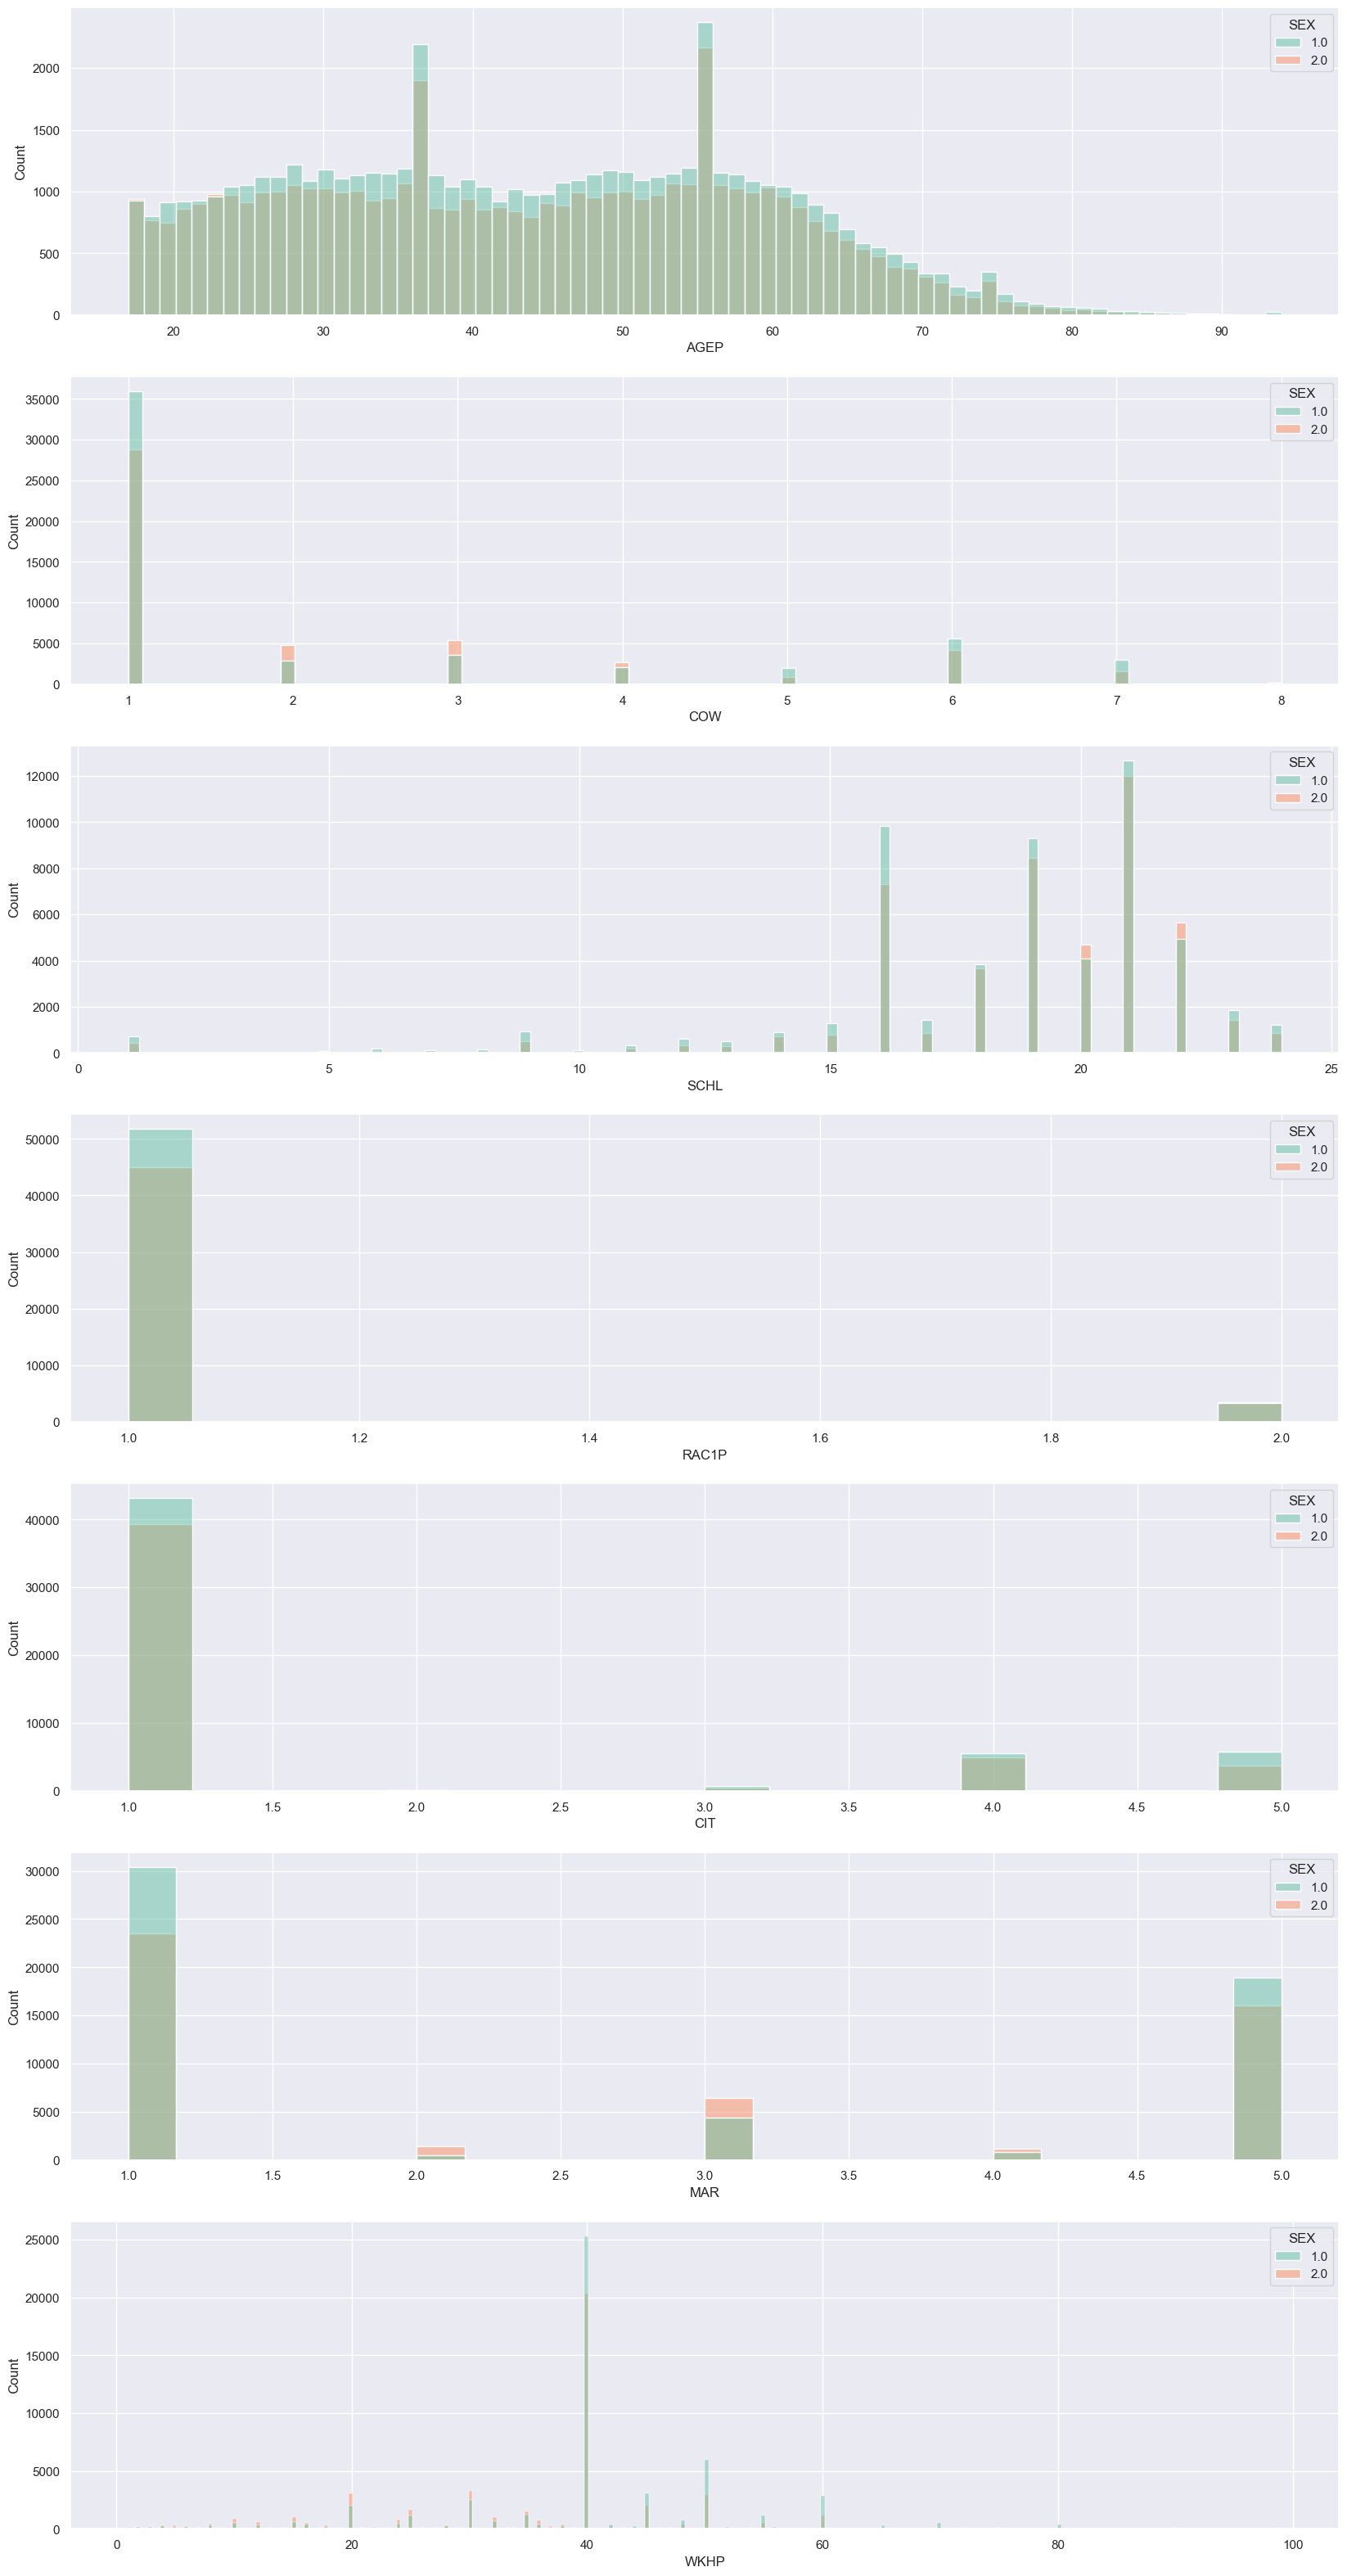

In [13]:
males = X_train[X_train['SEX'] == 1]
females = X_train[X_train['SEX'] == 2]

import matplotlib.pyplot as plt
import seaborn as sns
# plot feature distributions for both genders in one plot
fig, axes = plt.subplots(7, figsize=(20, 40))
for i, feature in enumerate(['AGEP', 'COW', 'SCHL', 'RAC1P', 'CIT', 'MAR','WKHP']):
    sns.histplot(data=X_train, x=feature, hue='SEX', ax=axes[i], palette='Set2')
plt.show()

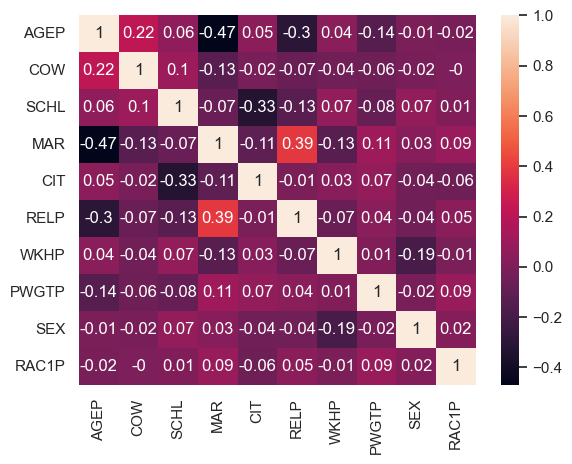

In [14]:
corr = X_train.corr()
sns.set(font_scale=1)
sns.heatmap(corr.round(2), annot=True)
sns.set_style('whitegrid', {'axes.grid' : False})
plt.show()

# 2.1 Data

In [15]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)
### groups now contain information about SEX and RAC1P
features.head()

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,SEX_Male,RAC1P_Black or African American alone,RAC1P_White alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [16]:
# Drop the "redundant" columns
features = features.drop(["RELP_Unmarried partner",
                          "CIT_U.S. citizen by naturalization",
                          "SEX_Male",
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm', 
                          "RAC1P_White alone" ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)

Columns with the protected features:
Column ID: 57 (SEX_Female)
Column ID: 58 (RAC1P_Black or African American alone)


In [17]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

N = 500 ### I am subsampling because it is slow on my machine

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]

In [20]:
## last columns of our data contains the protected features
protected = X_train[:,57:] 
nonprotected = X_train[:,:57]

In [24]:
protected.shape

(500, 2)

#### Task 2.2.
Use the following arguments in the `opt.fmin_funct`: `xtol=1e-4, ftol=1e-4,  maxfun=1000`

In [25]:
gammas = np.logspace(1e-5,1e-2,10)
###########
# YOUR CODE
###########

In [31]:
def sigmoid(x, eps = 1e-10):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1/(1+np.exp(-x))

def logistic_loss(y_true, y_pred, eps = 1e-10):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    return -np.mean(y_true*np.log(y_pred+eps) + (1-y_true)*np.log(1-y_pred+eps))

def l2_loss(beta):
    """
    L2-Regularisation
    """
    # L2 loss
    return np.sum(beta**2)

def fair_loss(y, y_pred, groups):
    """
    Group fairness Loss
    """
    n = y.shape[0]
    n1 = np.sum(groups == 1)
    n2 = np.sum(groups == 2)
    cost = 0
    return (cost/(n1*n2))

def compute_gradient(beta,X,y, groups, _lambda,_gamma):
    """Calculate the gradient - used for finding the best beta values. 
       You do not need to use groups and lambda (fmin_tnc expects same input as in func, that's why they are included here)"""
    grad = np.zeros(beta.shape)

    for i in range(len(grad)):
        if i == 0: # we do not want to regularize the intercept
            grad[i] = grad[i]
        else:
            grad[i] = grad[i] + _gamma * 2 * beta[i]
        
    return grad

def compute_cost(beta ,X,y, groups, _lambda, _gamma):
    """Computes cost function with constraints"""
    probs = sigmoid(X.dot(beta))
    log_loss = logistic_loss(y, probs)
    loss = log_loss + _lambda * fair_loss(y,X.dot(beta), groups) + _gamma * l2_loss(beta[1:])
    return loss

beta = np.random.rand(X_train.shape[1])
# set parameters
lambda_ = 0.1
gamma_ = 0.1
#
X = X_train
y = y_train
groups = group_train

beta = np.random.rand(57)
lambdas = np.linspace(1,1e5, 20)

########## This is the optimisation function
result = opt.fmin_tnc(func=compute_cost, x0=beta, fprime = compute_gradient, maxfun = 1000,
                         args = (nonprotected,y, groups, lambda_,1e-5), xtol=1e-4, ftol=1e-4)

ValueError: The user-provided objective function must return a scalar value.

#### Task 2.3
Use the following arguments in the `opt.fmin_funct`: ` xtol=1e-3, ftol=1e-3, approx_grad=True, maxfun=1000`

In [ ]:
lambdas = np.array([1e-3, 5e-3, 1e-2, 5e-2, 0.1, 1])
###########
# YOUR CODE
###########

In [ ]:
### CODE FROM HANNAH
def sigmoid(x):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1/(1+np.exp(-x))

def logistic_loss(y_true, y_pred, eps = 1e-9):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    # check whether that's the same as 1/m * sum()
    return -np.mean(y_true*np.log(y_pred + eps)+(1-y_true)*np.log(1-y_pred + eps))
    
def l2_loss(beta):
    """
    L2-Regularisation
    """
    return np.linalg.norm(beta)

def fair_loss(y_true, y_pred, grouping):
    """
    Group fairness Loss
    """
    n = y_true.shape[0]
    
    # SEX
    n1 = np.sum(grouping['SEX'] == 1)
    n2 = n - n1

    cost_sex = 0
    for i in range(n):
        for j in range(i+1, n):
            if y_true[i] == y_true[j]:
                if grouping['SEX'].iloc[i] != grouping['SEX'].iloc[j]:
                    cost_sex += (y_pred[i] - y_pred[j])**2                
    cost_sex = cost_sex/(n1*n2)
    # print(cost_sex)
    
    # RAC1P
    n1 = np.sum(grouping['RAC1P'] == 1)
    n2 = n - n1

    cost_race = 0
    for i in range(n):
        for j in range(i+1, n):
            if y_true[i] == y_true[j]:
                if grouping['RAC1P'].iloc[i] != grouping['RAC1P'].iloc[j]:
                    cost_race += (y_pred[i] - y_pred[j])**2                
    cost_race = cost_race/(n1*n2)
    # print(cost_race)
    
    # Is this right? Or how should the two fairness constraints be connected before applying the scaling?
    return cost_sex + cost_race


### not needed (?)
def compute_gradient(beta,X,y_true,_gamma): # y = y_true
    """Calculate the gradient - used for finding the best beta values. 
       You do not need to use groups and lambda (fmin_tnc expects same input as in func, that's why they are included here)"""
    grad = np.zeros(beta.shape)
    m = X.shape[0]
    y_pred = np.array(sigmoid(X.dot(beta))) # same as beta @ X.T?
    
    for i in range(len(grad)):
        if i == 0:
            # don't want to penalize the intercept
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) 
        else:
            # start with beta[1]
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) + 2* _gamma *beta[i] 
    #print(f'Gradient: {grad}')
    return grad


def compute_cost(beta , X, y_true, grouping, _lambda, _gamma):
    """Computes cost function with constraints"""
    y_pred = sigmoid(X.dot(beta)) 
    cost = logistic_loss(y_true, y_pred) + _lambda*fair_loss(y_true, y_pred, grouping) + _gamma*l2_loss(beta[1:]) # to not penalize the Intercept?
    #print(f'Cost: {cost}')
    return cost

In [ ]:
np.random.seed(0)
lambdas = np.array([1e-3, 5e-3, 1e-2, 5e-2, 0.1, 1])
betas = np.random.rand(X_train.shape[1])

opt.fmin_tnc(func=compute_cost, x0=betas, approx_grad = True, maxfun = 1000,
                         args = (X_train,y_train, group_train, lambdas[0], gammas[2]), ftol=1e-3, xtol=1e-3)